In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir
from scipy import stats

import uproot3

from scipy.stats import trim_mean
rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)
print(pd.__version__)

0.25.3


In [3]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

plot_style_1A = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2A = {'alpha': 0.5, 'density': False}


In [5]:
def get_Dataframe(path, name='Data', tag=None):
    Files = listdir(path) 
    #print (Files)
    df = None
    for i, f in enumerate(Files):
        #if( df is not None):
        #    if(df.shape[0]>100000): continue
        #if(i>10):continue
        if name not in f: continue
        filename = path+f
        if not(tag is None) and (tag not in f): continue
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        
        print (temp_file.keys()) 
        
        if(len(temp_file.keys())<1):
            print('could not find %s, skipping'%name)
            continue
        
        if( not(name in str(temp_file.keys()[0]))):
            print('could not find %s, skipping'%name)
            continue
        
        for key in temp_file[name].keys():
            #print (key)
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y",'gen_y',"e_*","gene*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*","Q2","y","e_*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    if( not(df is None)):
        print('Dataframe has a total of ', df.shape[0], ' entries')
    else:
        print ('Dataframe has no entry, it is None')
    print('####################################################################')

    return df


In [6]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [7]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('jet_px = jet_pt*cos(jet_phi)', inplace=True)
    temp.eval('jet_py = jet_pt*sin(jet_phi)', inplace=True)
    temp.eval('jet_pz = jet_pt*sinh(jet_eta)', inplace=True)
    temp.eval('jet_p = jet_pt*cosh(jet_eta)',inplace=True)
    temp.eval('jet_qt = sqrt( (jet_px + e_px)**2 + (jet_py + e_py)**2) ', inplace=True)
    temp.eval('jet_qtnorm = jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('jet_phi = arctan(jet_py/jet_px)',inplace=True)
    
    temp.eval('qt_px = jet_px + e_px', inplace=True)
    temp.eval('qt_py = jet_py + e_py', inplace=True)
    temp.eval('qt_phi = arctan(qt_py/qt_px)',inplace=True)
    temp.eval('qt_dot_ept = (qt_px*e_px + qt_py*e_py)/(jet_qt*e_pt)', inplace=True)
    temp.eval('qt_dphi = arccos(qt_dot_ept)', inplace=True)
    temp.eval('qt_cos2phi = cos(2*qt_dphi)', inplace=True)

    temp.eval('jet_dphi = 3.14159265359 -abs(e_phi-jet_phi)',inplace=True)
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('Q = sqrt(Q2)', inplace=True)
    temp.eval('pthoverpte = pth/e_pt', inplace=True)
    temp = applyCut(temp, 'pass_reco==0 | ptmiss < 10', 'ptmiss<10')

    temp = applyCut(temp, 'pass_reco==0 | 0.08 < y < 0.7', '0.08 < y < 0.7')
    temp = applyCut(temp, 'pass_reco==0 | Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt>5.0', 'jet pT > 5 GeV')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt<150.0', 'jet pT < 150 GeV')

    temp = applyCut(temp, 'pass_reco==0 | jet_eta>-1.5', 'jet eta > -1.5')
    temp = applyCut(temp, 'pass_reco==0 | jet_eta<2.75', 'jet eta < 2.75')

    if(isMC):
        temp = applyCut(temp,'pass_truth>0',' pass_truth>0')

        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gen_Q    = sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('genjet_px = genjet_pt*cos(genjet_phi)', inplace=True)
        temp.eval('genjet_py = genjet_pt*sin(genjet_phi)', inplace=True)
        temp.eval('genjet_pz = genjet_pt*sinh(genjet_eta)', inplace=True)
        temp.eval('genjet_p = genjet_pt*cosh(genjet_eta)',inplace=True)

        
        temp.eval('genjet_qt = sqrt( (genjet_px + gene_px)**2 + (genjet_py + gene_py)**2) ', inplace=True)
        temp.eval('genjet_qtnorm = genjet_qt/sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_phi = arctan(gene_py/gene_px)', inplace=True)
        temp.eval('genjet_phi = arctan(genjet_py/genjet_px)',inplace=True)
        temp.eval('genjet_dphi = 3.14159265359- abs(gene_phi-genjet_phi)',inplace=True)
        
        temp.eval('genqt_px = genjet_px + gene_px', inplace=True)
        temp.eval('genqt_py = genjet_py + gene_py', inplace=True)
        temp.eval('genqt_phi = arctan(genqt_py/genqt_px)',inplace=True)
        temp.eval('genqt_dot_ept = (genqt_px*gene_px + genqt_py*gene_py)/(genjet_qt*gene_pt)', inplace=True)
        temp.eval('genqt_dphi = arccos(genqt_dot_ept)', inplace=True)
        temp.eval('genqt_cos2phi = cos(2*genqt_dphi)', inplace=True)
        
        temp.eval('res_pt = ((jet_pt-genjet_pt)/genjet_pt)',inplace=True)
        temp.eval('res_p = ((jet_p-genjet_p)/genjet_p)',inplace=True)

        temp.eval('res_qt = (jet_qt/jet_pt-genjet_qt/genjet_pt)',inplace=True)

    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [8]:
#mc_name = 'Django'
#altmc_name = 'Rapgap'

mc_name = 'Rapgap'
altmc_name = 'Django'

In [9]:
mc_tag = 'nominal' ##could be "sys_0 or sys_1, etc"
data_tag  = 'nominal'
period = 'ep0607'

In [10]:

path = '/home/miguel/data/hera/'
data = get_Dataframe(path, name='Data', tag=data_tag)

filename is /home/miguel/data/hera/Data_Eplus0607_0.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_2.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_3.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_1.nominal.root
[b'Data;1']
####################################################################
Dataframe has a total of  375783  entries
####################################################################


## Get Signal MC

In [11]:
%%time 
mc = get_Dataframe(path, name=mc_name, tag=mc_tag)


filename is /home/miguel/data/hera/Rapgap_Eplus0607_116.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_8.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_101.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_107.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_131.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_103.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_117.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_4.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_136.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_112.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_144.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_150.nominal.root
[b'Rapgap;1']
filename

In [12]:
%%time 

altmc = get_Dataframe(path, name=altmc_name, tag=mc_tag)


filename is /home/miguel/data/hera/Django_Eplus0607_8.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_129.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_137.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_134.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_13.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_121.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_151.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_7.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_3.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_116.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_126.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_132.nominal.root
[b'Django;1']
filename is

In [13]:
%%time
mc_up = get_Dataframe(path, name=mc_name, tag='sys_0')

filename is /home/miguel/data/hera/Rapgap_Eplus0607_147.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_114.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_116.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_117.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_3.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_8.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_143.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_145.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_139.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_108.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_6.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_126.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera

In [14]:
%%time
altmc_up = get_Dataframe(path, name=mc_name, tag='sys_0')

filename is /home/miguel/data/hera/Rapgap_Eplus0607_147.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_114.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_116.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_117.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_3.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_8.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_143.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_145.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_139.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_108.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_6.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_126.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera

## Define the pass_reco and pass_tuth flags. i.e. whether row in the dataframe jet has a reco-level jet, and whether it has a valid truth-level jet. 

In [15]:
%%time 
mc['pass_reco'] = np.where(mc['jet_pt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['genjet_pt']*mc['Q2']>0, 1, 0)

altmc['pass_reco'] = np.where(altmc['jet_pt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['genjet_pt']*altmc['Q2']>0, 1, 0)




CPU times: user 1.33 s, sys: 619 ms, total: 1.95 s
Wall time: 1.55 s


In [17]:
mc_up['pass_reco'] = np.where(mc_up['jet_pt']>0, 1, 0)
mc_up['pass_truth'] = np.where(mc_up['genjet_pt']*mc_up['Q2']>0, 1, 0)

altmc_up['pass_reco'] = np.where(altmc_up['jet_pt']>0, 1, 0)
altmc_up['pass_truth'] = np.where(altmc_up['genjet_pt']*altmc_up['Q2']>0, 1, 0)


In [20]:
%%time 
data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)

print('Selecting data events\n')
data = applyCutsJets(data)
data.keys()

Selecting data events

ptmiss<10 258684  fraction kept: 100.0
0.08 < y < 0.7 258684  fraction kept: 100.0
Q2>150 258684  fraction kept: 100.0
jet pT > 5 GeV 258684  fraction kept: 100.0
jet pT < 150 GeV 258684  fraction kept: 100.0
jet eta > -1.5 258684  fraction kept: 100.0
jet eta < 2.75 258684  fraction kept: 100.0
CPU times: user 274 ms, sys: 13.2 ms, total: 287 ms
Wall time: 172 ms


Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'Q2', 'y', 'e_px',
       'e_py', 'e_pz', 'wgt', 'vertex_z', 'ptmiss', 'ptratio_da',
       'ptratio_ele', 'Empz', 'pth', 'pass_reco', 'jet_px', 'jet_py', 'jet_pz',
       'jet_p', 'jet_qt', 'jet_qtnorm', 'e_pt', 'e_phi', 'qt_px', 'qt_py',
       'qt_phi', 'qt_dot_ept', 'qt_dphi', 'qt_cos2phi', 'logQ2', 'Q',
       'pthoverpte'],
      dtype='object')

In [19]:
%%time 
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('Selecting MC events\n')
altmc   = applyCutsJets(altmc, isMC=True)



Selecting MC events

ptmiss<10 88561297  fraction kept: 99.7
0.08 < y < 0.7 86599620  fraction kept: 97.8
Q2>150 84206452  fraction kept: 97.2
jet pT > 5 GeV 84206452  fraction kept: 100.0
jet pT < 150 GeV 84206452  fraction kept: 100.0
jet eta > -1.5 84184454  fraction kept: 100.0
jet eta < 2.75 84183898  fraction kept: 100.0
 pass_truth>0 22142629  fraction kept: 26.3
Selecting MC events

ptmiss<10 98331422  fraction kept: 99.6
0.08 < y < 0.7 96427587  fraction kept: 98.1
Q2>150 93632537  fraction kept: 97.1
jet pT > 5 GeV 93632537  fraction kept: 100.0
jet pT < 150 GeV 93632536  fraction kept: 100.0
jet eta > -1.5 93609301  fraction kept: 100.0
jet eta < 2.75 93608656  fraction kept: 100.0
 pass_truth>0 22574692  fraction kept: 24.1
CPU times: user 1min 45s, sys: 46.9 s, total: 2min 32s
Wall time: 2min 2s


In [21]:
print('Selecting MC events\n')
mc_up  = applyCutsJets(mc_up, isMC=True)
print('Selecting MC events\n')
altmc_up   = applyCutsJets(altmc_up, isMC=True)

Selecting MC events

ptmiss<10 87125175  fraction kept: 99.7
0.08 < y < 0.7 85219953  fraction kept: 97.8
Q2>150 82865796  fraction kept: 97.2
jet pT > 5 GeV 82865796  fraction kept: 100.0
jet pT < 150 GeV 82865796  fraction kept: 100.0
jet eta > -1.5 82844092  fraction kept: 100.0
jet eta < 2.75 82843540  fraction kept: 100.0
 pass_truth>0 21790225  fraction kept: 26.3
Selecting MC events

ptmiss<10 87125175  fraction kept: 99.7
0.08 < y < 0.7 85219953  fraction kept: 97.8
Q2>150 82865796  fraction kept: 97.2
jet pT > 5 GeV 82865796  fraction kept: 100.0
jet pT < 150 GeV 82865796  fraction kept: 100.0
jet eta > -1.5 82844092  fraction kept: 100.0
jet eta < 2.75 82843540  fraction kept: 100.0
 pass_truth>0 21790225  fraction kept: 26.3


## Check calibration

[7.5645, 8.785, 10.2025, 11.847999999999999, 13.759, 15.979, 18.557000000000002, 21.5505, 25.027, 29.064, 33.7525, 39.1975, 45.5205, 52.864000000000004, 61.392, 71.2955, 82.797, 96.154, 111.66550000000001]


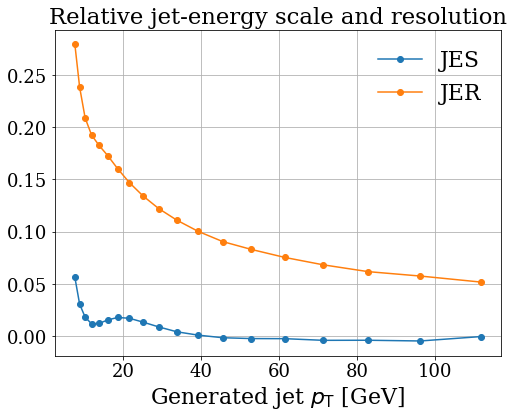

<Figure size 432x288 with 0 Axes>

In [26]:
fig = plt.figure( figsize=(8, 6))
df = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['genjet_pt'], bins=np.geomspace(7,120,20)))['res_pt']
df = df.agg(['mean', 'std', 'size'])
df = df.reset_index()

x = [i.mid for i in df['genjet_pt']]
print (x)
plt.plot(x,df['mean'],'o-',label='JES')
plt.plot(x,df['std'],'o-',label='JER')
plt.xlabel('Generated jet $p_{\mathrm{T}}$ [GeV]',fontsize=22)
plt.legend(fontsize=22)
plt.title('Relative jet-energy scale and resolution')
plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/Jetperformance_jetpt.pdf')
fig.savefig('figures/Jetperformance_jetpt.png')

[10.5275, 11.6385, 12.866499999999998, 14.224, 15.725000000000001, 17.384, 19.218, 21.2455, 23.487000000000002, 25.9655, 28.7055, 31.733999999999998, 35.082, 38.783500000000004, 42.876, 47.4, 52.400999999999996, 57.93, 64.04249999999999, 70.8, 78.27, 86.52799999999999, 95.658, 105.751, 116.9085, 129.244, 142.881, 157.9565, 174.623, 193.048, 213.41649999999998, 235.934, 260.828, 288.3485, 318.77250000000004, 352.40700000000004, 389.59000000000003, 430.696, 476.1395]


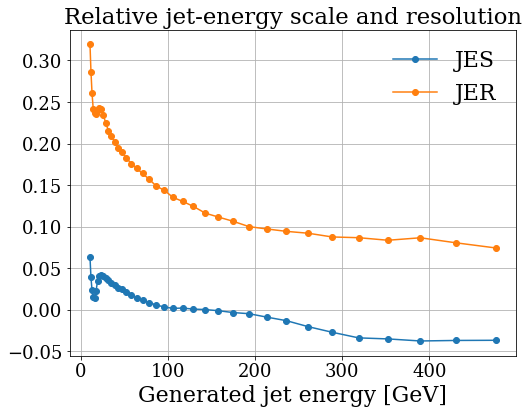

<Figure size 432x288 with 0 Axes>

In [24]:
fig = plt.figure( figsize=(8, 6))
df = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['genjet_p'], bins=np.geomspace(10,500,40)))['res_p']
df = df.agg(['mean', 'std', 'size'])
df = df.reset_index()

x = [i.mid for i in df['genjet_p']]
print (x)
plt.plot(x,df['mean'],'o-',label='JES')
plt.plot(x,df['std'],'o-',label='JER')
plt.xlabel('Generated jet energy [GeV]',fontsize=22)
plt.legend(fontsize=22)
plt.title('Relative jet-energy scale and resolution')
plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/Jetperformance_energy.png')

[7.5645, 8.785, 10.2025, 11.847999999999999, 13.759, 15.979, 18.557000000000002, 21.5505, 25.027, 29.064, 33.7525, 39.1975, 45.5205, 52.864000000000004, 61.392, 71.2955, 82.797, 96.154, 111.66550000000001]


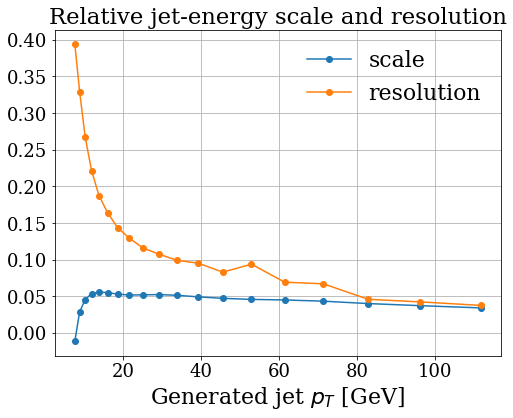

<Figure size 432x288 with 0 Axes>

In [27]:

fig = plt.figure( figsize=(8, 6))
df = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['genjet_pt'], bins=np.geomspace(7,120,20)))['res_qt']
df = df.agg(['mean', 'std', 'size'])
df = df.reset_index()

x = [i.mid for i in df['genjet_pt']]
print (x)
plt.plot(x,df['mean'],'o-',label='scale')
plt.plot(x,df['std'],'o-',label='resolution')
plt.xlabel('Generated jet $p_{T}$ [GeV]',fontsize=22)
plt.legend(fontsize=22)
plt.title('Relative jet-energy scale and resolution')
plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/Jetperformance_jetpt.png')

[-0.9079999999999999, -0.724, -0.5395, -0.355, -0.17095, 0.013049999999999999, 0.19699999999999998, 0.38149999999999995, 0.5660000000000001, 0.75, 0.9339999999999999, 1.1185, 1.303, 1.487, 1.6709999999999998, 1.855, 2.0395000000000003, 2.224, 2.408]


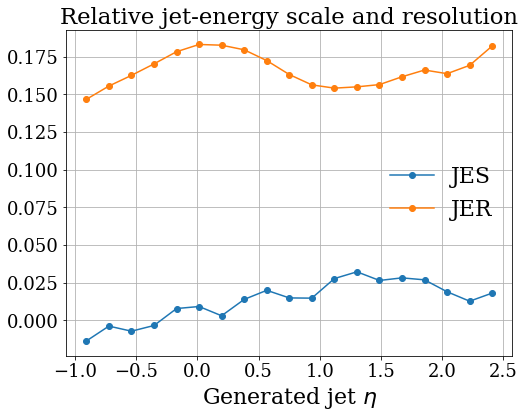

<Figure size 432x288 with 0 Axes>

In [28]:
fig = plt.figure( figsize=(8, 6))
query = 'pass_reco==1 and genjet_pt>10'
df = mc.query(query).groupby(pd.cut(mc.query(query)['genjet_eta'], bins=np.linspace(-1.0,2.5,20)))['res_pt'].agg(['mean', 'std', 'size'])
df = df.reset_index()

x = [i.mid for i in df['genjet_eta']]
print (x)
plt.plot(x,df['mean'],'o-',label='JES')
plt.plot(x,df['std'],'o-',label='JER')
plt.xlabel('Generated jet $\eta$',fontsize=22)
plt.legend(fontsize=22)
plt.title('Relative jet-energy scale and resolution')
plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/Jetperformance_jeteta.png')

## Average HFS pT / DA pT vs jet pT

              jet_pt      mean       std     size
0       (5.0, 6.565]  0.959841  0.152419  1737805
1      (6.565, 8.62]  0.954153  0.146802  2135103
2     (8.62, 11.319]  0.967009  0.136786  3047288
3   (11.319, 14.862]  0.991666  0.132239  3491926
4   (14.862, 19.514]  1.029290  0.142134  2901226
5   (19.514, 25.623]  1.057922  0.150705  1996417
6   (25.623, 33.643]  1.053105  0.136384  1106580
7   (33.643, 44.175]  1.039002  0.110425   519669
8   (44.175, 58.003]  1.027177  0.090788   198385
9    (58.003, 76.16]  1.019428  0.075512    69133
10    (76.16, 100.0]  1.025648  0.064568    15418


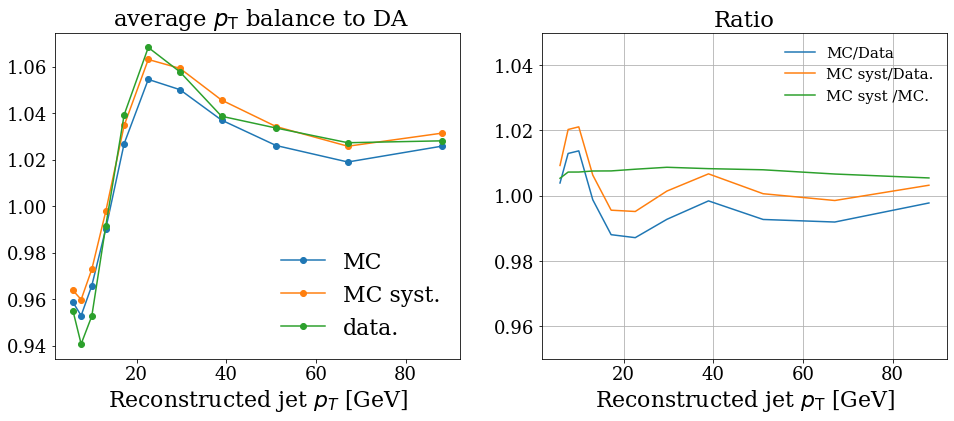

CPU times: user 6.15 s, sys: 2.27 s, total: 8.42 s
Wall time: 7.93 s


<Figure size 432x288 with 0 Axes>

In [30]:
%%time
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()

trim_mean = {}
bins = np.geomspace(5,100,12)
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['jet_pt'], bins=bins))['ptratio_da']
trim_mean['MC'] = df_mc.apply(stats.trim_mean, 0.025)
df_mc = df_mc.agg(['mean', 'std', 'size']).reset_index()
print (df_mc)
x = [i.mid for i in df_mc['jet_pt']]
ax[0].plot(x,trim_mean['MC'],'o-',label='MC')



df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['jet_pt'], bins=bins))['ptratio_da']
trim_mean['MCsys'] = df_mc_up.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['MCsys'],'o-',label='MC syst.')


df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['jet_pt'], bins=bins))['ptratio_da']
trim_mean['data'] = df_data.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['data'],'o-',label='data.')



ax[0].set_xlabel('Reconstructed jet $p_{T}$ [GeV]',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{\mathrm{T}}$ balance to DA')

ratio = np.true_divide(trim_mean['MC'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC/Data')
ratio = np.true_divide(trim_mean['MCsys'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC syst/Data.')

ratio = np.true_divide(trim_mean['MCsys'],trim_mean['MC'])
ax[1].plot(x,ratio,label='MC syst /MC.')

ax[1].set_ylim(0.95,1.05)
#ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
#ax[1].axhline(y=1.0,color='black')#fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')

ax[1].set_title('Ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed jet $p_{\mathrm{T}}$ [GeV]',fontsize=22)

plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_DA_jetpt.png')
fig.savefig('figures/JetCalibrationTest_DA_jetpt.pdf')

              jet_eta      mean       std     size
0      (-1.0, -0.682]  0.988990  0.136896  1096216
1    (-0.682, -0.364]  0.992687  0.145591  1586272
2   (-0.364, -0.0455]  1.002104  0.155702  1900500
3    (-0.0455, 0.273]  1.001119  0.160026  1993967
4      (0.273, 0.591]  1.003042  0.155311  2013967
5      (0.591, 0.909]  0.998300  0.142760  1897820
6      (0.909, 1.227]  1.002188  0.135536  1748259
7      (1.227, 1.545]  1.006377  0.134654  1542613
8      (1.545, 1.864]  1.007761  0.136472  1239336
9      (1.864, 2.182]  1.004593  0.133411   900050
10       (2.182, 2.5]  1.003779  0.133752   544884


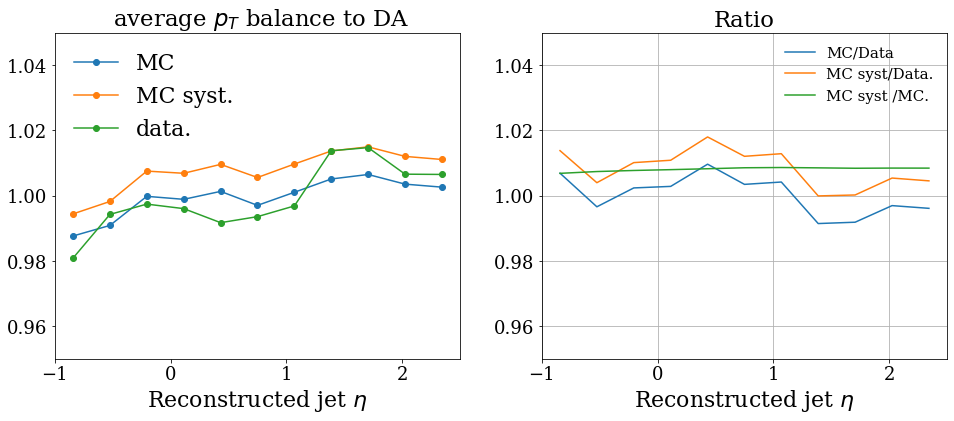

CPU times: user 6.26 s, sys: 2.19 s, total: 8.45 s
Wall time: 7.98 s


<Figure size 432x288 with 0 Axes>

In [32]:
%%time
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()

trim_mean = {}
bins=np.linspace(-1.0,2.5,12)
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['jet_eta'], bins=bins))['ptratio_da']
trim_mean['MC'] = df_mc.apply(stats.trim_mean, 0.025)
df_mc = df_mc.agg(['mean', 'std', 'size']).reset_index()
print (df_mc)
x = [i.mid for i in df_mc['jet_eta']]
ax[0].plot(x,trim_mean['MC'],'o-',label='MC')



df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['jet_eta'], bins=bins))['ptratio_da']
trim_mean['MCsys'] = df_mc_up.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['MCsys'],'o-',label='MC syst.')


df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['jet_eta'], bins=bins))['ptratio_da']
trim_mean['data'] = df_data.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['data'],'o-',label='data.')



ax[0].set_xlabel('Reconstructed jet $\eta$',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to DA')

ratio = np.true_divide(trim_mean['MC'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC/Data')
ratio = np.true_divide(trim_mean['MCsys'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC syst/Data.')

ratio = np.true_divide(trim_mean['MCsys'],trim_mean['MC'])
ax[1].plot(x,ratio,label='MC syst /MC.')

ax[1].set_ylim(0.95,1.05)
#ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
#ax[1].axhline(y=1.0,color='black')#fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')

ax[1].set_title('Ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed jet $\eta$',fontsize=22)
ax[0].set_ylim(0.95,1.05)

plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_DA_jeteta.png')
fig.savefig('figures/JetCalibrationTest_DA_jeteta.pdf')

              jet_pt      mean       std     size
0       (5.0, 6.565]  0.982628  0.194064  1737805
1      (6.565, 8.62]  0.974480  0.186996  2135103
2     (8.62, 11.319]  0.988079  0.174430  3047288
3   (11.319, 14.862]  1.014184  0.167397  3491926
4   (14.862, 19.514]  1.052802  0.175250  2901226
5   (19.514, 25.623]  1.080413  0.181281  1996417
6   (25.623, 33.643]  1.071517  0.161096  1106580
7   (33.643, 44.175]  1.050850  0.127579   519669
8   (44.175, 58.003]  1.035008  0.101356   198385
9    (58.003, 76.16]  1.022206  0.080372    69133
10    (76.16, 100.0]  1.025266  0.062490    15418


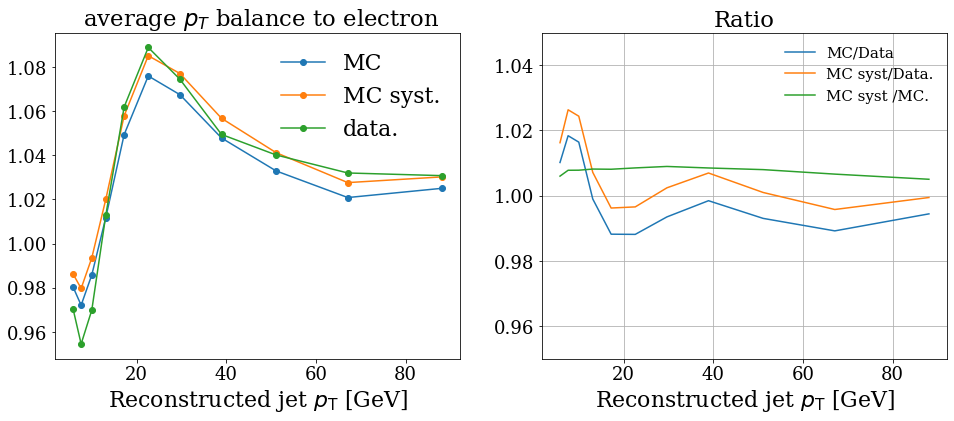

CPU times: user 6.13 s, sys: 2.12 s, total: 8.26 s
Wall time: 7.79 s


<Figure size 432x288 with 0 Axes>

In [34]:
%%time
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()

trim_mean = {}
bins = np.geomspace(5,100,12)
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['jet_pt'], bins=bins))['ptratio_ele']
trim_mean['MC'] = df_mc.apply(stats.trim_mean, 0.025)
df_mc = df_mc.agg(['mean', 'std', 'size']).reset_index()
print (df_mc)
x = [i.mid for i in df_mc['jet_pt']]
ax[0].plot(x,trim_mean['MC'],'o-',label='MC')



df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['jet_pt'], bins=bins))['ptratio_ele']
trim_mean['MCsys'] = df_mc_up.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['MCsys'],'o-',label='MC syst.')


df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['jet_pt'], bins=bins))['ptratio_ele']
trim_mean['data'] = df_data.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['data'],'o-',label='data.')



ax[0].set_xlabel('Reconstructed jet $p_{\mathrm{T}}$ [GeV]',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to electron')

ratio = np.true_divide(trim_mean['MC'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC/Data')
ratio = np.true_divide(trim_mean['MCsys'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC syst/Data.')

ratio = np.true_divide(trim_mean['MCsys'],trim_mean['MC'])
ax[1].plot(x,ratio,label='MC syst /MC.')

ax[1].set_ylim(0.95,1.05)
#ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
#ax[1].axhline(y=1.0,color='black')#fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')

ax[1].set_title('Ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed jet $p_{\mathrm{T}}$ [GeV]',fontsize=22)

plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_electron_jetpt.png')
fig.savefig('figures/JetCalibrationTest_electron_jetpt.pdf')

              jet_eta      mean       std     size
0      (-1.0, -0.682]  1.015362  0.183055  1096216
1    (-0.682, -0.364]  1.019707  0.188123  1586272
2   (-0.364, -0.0455]  1.028882  0.194842  1900500
3    (-0.0455, 0.273]  1.025568  0.194929  1993967
4      (0.273, 0.591]  1.025652  0.186122  2013967
5      (0.591, 0.909]  1.018284  0.170772  1897820
6      (0.909, 1.227]  1.020679  0.162016  1748259
7      (1.227, 1.545]  1.023459  0.160603  1542613
8      (1.545, 1.864]  1.023592  0.164234  1239336
9      (1.864, 2.182]  1.019614  0.163854   900050
10       (2.182, 2.5]  1.017983  0.165496   544884


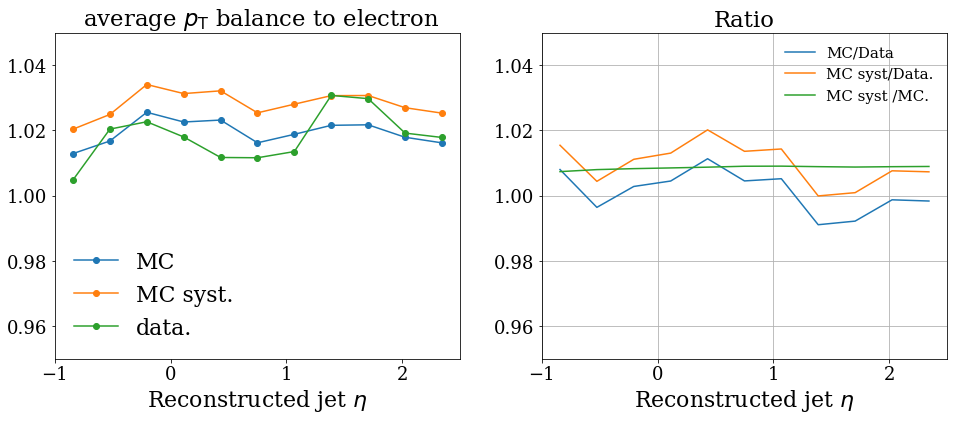

CPU times: user 6.45 s, sys: 2.18 s, total: 8.63 s
Wall time: 8.11 s


<Figure size 432x288 with 0 Axes>

In [37]:
%%time
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()

trim_mean = {}
bins=np.linspace(-1.0,2.5,12)
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['jet_eta'], bins=bins))['ptratio_ele']
trim_mean['MC'] = df_mc.apply(stats.trim_mean, 0.025)
df_mc = df_mc.agg(['mean', 'std', 'size']).reset_index()
print (df_mc)
x = [i.mid for i in df_mc['jet_eta']]
ax[0].plot(x,trim_mean['MC'],'o-',label='MC')



df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['jet_eta'], bins=bins))['ptratio_ele']
trim_mean['MCsys'] = df_mc_up.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['MCsys'],'o-',label='MC syst.')


df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['jet_eta'], bins=bins))['ptratio_ele']
trim_mean['data'] = df_data.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['data'],'o-',label='data.')



ax[0].set_xlabel('Reconstructed jet $\eta$',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{\mathrm{T}}$ balance to electron')

ratio = np.true_divide(trim_mean['MC'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC/Data')
ratio = np.true_divide(trim_mean['MCsys'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC syst/Data.')

ratio = np.true_divide(trim_mean['MCsys'],trim_mean['MC'])
ax[1].plot(x,ratio,label='MC syst /MC.')

ax[1].set_ylim(0.95,1.05)
#ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
#ax[1].axhline(y=1.0,color='black')#fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')

ax[1].set_title('Ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed jet $\eta$',fontsize=22)
ax[0].set_ylim(0.95,1.05)

plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_electron_jeteta.png')
fig.savefig('figures/JetCalibrationTest_electron_jeteta.pdf')

## As afunction of electron variables

                 y      mean       std     size
0     (0.2, 0.245]  1.000027  0.147031  1648808
1   (0.245, 0.291]  1.005615  0.152188  1613726
2   (0.291, 0.336]  1.010143  0.155416  1541402
3   (0.336, 0.382]  1.012387  0.155867  1448712
4   (0.382, 0.427]  1.012586  0.154130  1344289
5   (0.427, 0.473]  1.010464  0.150077  1225935
6   (0.473, 0.518]  1.006364  0.145041  1106662
7   (0.518, 0.564]  1.000476  0.140191   983681
8   (0.564, 0.609]  0.992975  0.134369   869060
9   (0.609, 0.655]  0.979209  0.124426   734969
10    (0.655, 0.7]  0.955043  0.113859   503663


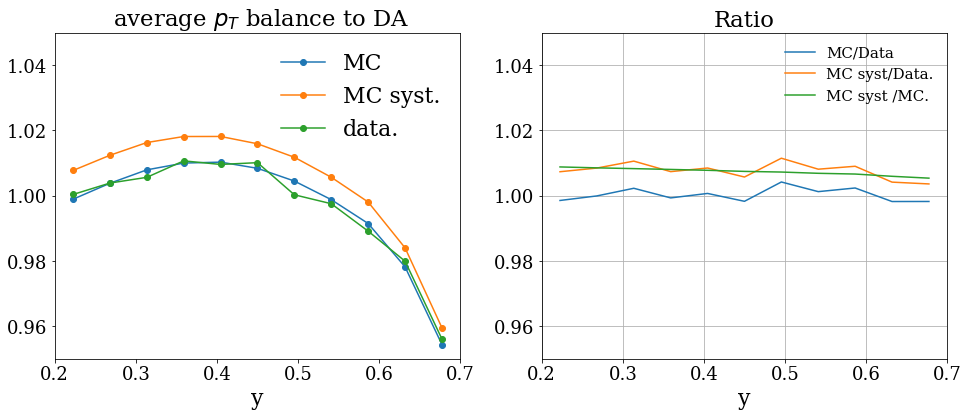

CPU times: user 6.36 s, sys: 2.15 s, total: 8.51 s
Wall time: 8.04 s


<Figure size 432x288 with 0 Axes>

In [39]:
%%time
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()

trim_mean = {}
bins=np.linspace(0.2,0.7,12)

df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['y'], bins=bins))['ptratio_da']
trim_mean['MC'] = df_mc.apply(stats.trim_mean, 0.025)
df_mc = df_mc.agg(['mean', 'std', 'size']).reset_index()
print (df_mc)
x = [i.mid for i in df_mc['y']]
ax[0].plot(x,trim_mean['MC'],'o-',label='MC')



df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['y'], bins=bins))['ptratio_da']
trim_mean['MCsys'] = df_mc_up.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['MCsys'],'o-',label='MC syst.')


df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['y'], bins=bins))['ptratio_da']
trim_mean['data'] = df_data.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['data'],'o-',label='data.')



ax[0].set_xlabel('y',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to DA')

ratio = np.true_divide(trim_mean['MC'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC/Data')
ratio = np.true_divide(trim_mean['MCsys'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC syst/Data.')

ratio = np.true_divide(trim_mean['MCsys'],trim_mean['MC'])
ax[1].plot(x,ratio,label='MC syst /MC.')

ax[1].set_ylim(0.95,1.05)
#ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
#ax[1].axhline(y=1.0,color='black')#fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')

ax[1].set_title('Ratio')
ax[1].legend()
ax[1].set_xlabel('y',fontsize=22)
ax[0].set_ylim(0.95,1.05)

plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_DA_y.png')
fig.savefig('figures/JetCalibrationTest_DA_y.pdf')

                 y      mean       std     size
0     (0.2, 0.245]  1.011236  0.161239  1648808
1   (0.245, 0.291]  1.019287  0.170476  1613726
2   (0.291, 0.336]  1.026591  0.178463  1541402
3   (0.336, 0.382]  1.032186  0.184572  1448712
4   (0.382, 0.427]  1.036684  0.189832  1344289
5   (0.427, 0.473]  1.039177  0.193951  1225935
6   (0.473, 0.518]  1.040012  0.197649  1106662
7   (0.518, 0.564]  1.039845  0.203558   983681
8   (0.564, 0.609]  1.038447  0.208358   869060
9   (0.609, 0.655]  1.030483  0.208311   734969
10    (0.655, 0.7]  1.011095  0.196256   503663


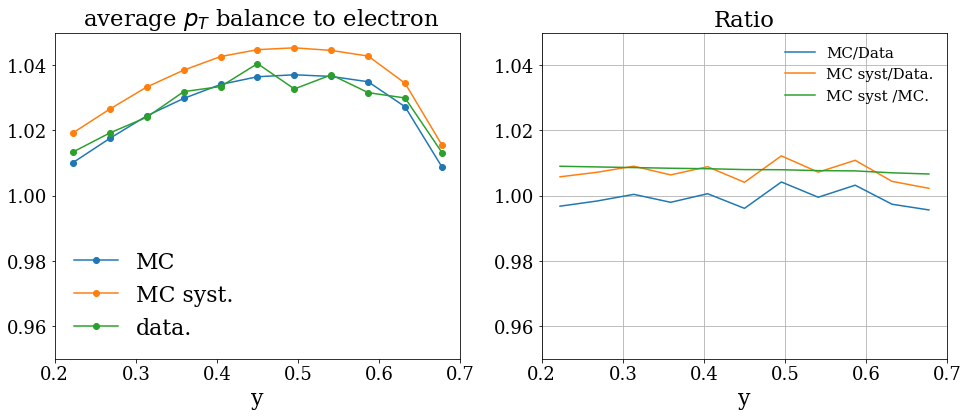

CPU times: user 6.31 s, sys: 2.2 s, total: 8.51 s
Wall time: 8.04 s


<Figure size 432x288 with 0 Axes>

In [40]:
%%time
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()

trim_mean = {}
bins=np.linspace(0.2,0.7,12)

df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['y'], bins=bins))['ptratio_ele']
trim_mean['MC'] = df_mc.apply(stats.trim_mean, 0.025)
df_mc = df_mc.agg(['mean', 'std', 'size']).reset_index()
print (df_mc)
x = [i.mid for i in df_mc['y']]
ax[0].plot(x,trim_mean['MC'],'o-',label='MC')



df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['y'], bins=bins))['ptratio_ele']
trim_mean['MCsys'] = df_mc_up.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['MCsys'],'o-',label='MC syst.')


df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['y'], bins=bins))['ptratio_ele']
trim_mean['data'] = df_data.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['data'],'o-',label='data.')



ax[0].set_xlabel('y',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to electron')

ratio = np.true_divide(trim_mean['MC'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC/Data')
ratio = np.true_divide(trim_mean['MCsys'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC syst/Data.')

ratio = np.true_divide(trim_mean['MCsys'],trim_mean['MC'])
ax[1].plot(x,ratio,label='MC syst /MC.')

ax[1].set_ylim(0.95,1.05)
#ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
#ax[1].axhline(y=1.0,color='black')#fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')

ax[1].set_title('Ratio')
ax[1].legend()
ax[1].set_xlabel('y',fontsize=22)
ax[0].set_ylim(0.95,1.05)

plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_electron_y.png')
fig.savefig('figures/JetCalibrationTest_electron_y.pdf')

         logQ2      mean       std     size
0   (2.0, 2.2]  1.038197  0.233504   505578
1   (2.2, 2.4]  1.025604  0.207301  5468751
2   (2.4, 2.6]  1.019326  0.179969  4599330
3   (2.6, 2.8]  1.020351  0.160847  2979873
4   (2.8, 3.0]  1.017305  0.142814  1745605
5   (3.0, 3.2]  1.011317  0.122944  1011243
6   (3.2, 3.4]  1.008613  0.106650   505057
7   (3.4, 3.6]  1.005607  0.095948   228501
8   (3.6, 3.8]  1.002265  0.083250   117231
9   (3.8, 4.0]  1.005127  0.071926    43764
10  (4.0, 4.2]  1.005716  0.063219    12516


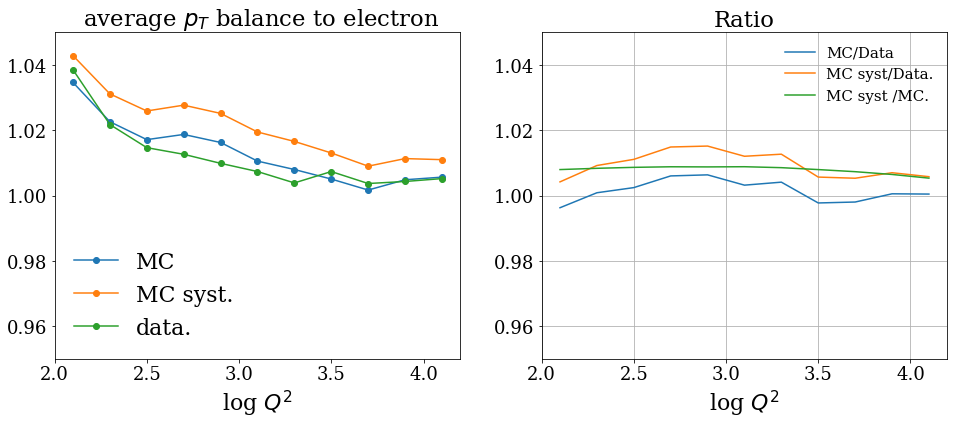

<Figure size 432x288 with 0 Axes>

In [41]:
bins=np.linspace(2,4.2,12)
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()

trim_mean = {}

df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['logQ2'], bins=bins))['ptratio_ele']
trim_mean['MC'] = df_mc.apply(stats.trim_mean, 0.025)
df_mc = df_mc.agg(['mean', 'std', 'size']).reset_index()
print (df_mc)
x = [i.mid for i in df_mc['logQ2']]
ax[0].plot(x,trim_mean['MC'],'o-',label='MC')



df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['logQ2'], bins=bins))['ptratio_ele']
trim_mean['MCsys'] = df_mc_up.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['MCsys'],'o-',label='MC syst.')


df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['logQ2'], bins=bins))['ptratio_ele']
trim_mean['data'] = df_data.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['data'],'o-',label='data.')



ax[0].set_xlabel('log $Q^{2}$',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to electron')

ratio = np.true_divide(trim_mean['MC'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC/Data')
ratio = np.true_divide(trim_mean['MCsys'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC syst/Data.')

ratio = np.true_divide(trim_mean['MCsys'],trim_mean['MC'])
ax[1].plot(x,ratio,label='MC syst /MC.')

ax[1].set_ylim(0.95,1.05)
#ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
#ax[1].axhline(y=1.0,color='black')#fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')

ax[1].set_title('Ratio')
ax[1].legend()
ax[1].set_xlabel('log $Q^{2}$',fontsize=22)
ax[0].set_ylim(0.95,1.05)

plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_electron_logQ2.png')
fig.savefig('figures/JetCalibrationTest_electron_logQ2.pdf')

         logQ2      mean       std     size
0   (2.0, 2.2]  0.996877  0.166792   505578
1   (2.2, 2.4]  0.997864  0.160196  5468751
2   (2.4, 2.6]  0.998527  0.148857  4599330
3   (2.6, 2.8]  1.002685  0.137921  2979873
4   (2.8, 3.0]  1.002201  0.125290  1745605
5   (3.0, 3.2]  0.999475  0.113216  1011243
6   (3.2, 3.4]  0.998457  0.100220   505057
7   (3.4, 3.6]  0.996878  0.092168   228501
8   (3.6, 3.8]  0.997035  0.082677   117231
9   (3.8, 4.0]  0.999859  0.074040    43764
10  (4.0, 4.2]  1.003294  0.067475    12516


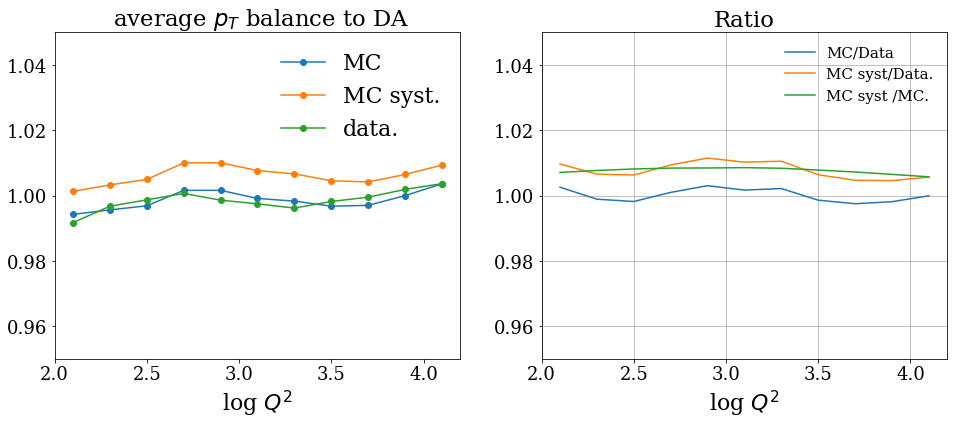

<Figure size 432x288 with 0 Axes>

In [42]:
bins=np.linspace(2,4.2,12)
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()

trim_mean = {}

df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['logQ2'], bins=bins))['ptratio_da']
trim_mean['MC'] = df_mc.apply(stats.trim_mean, 0.025)
df_mc = df_mc.agg(['mean', 'std', 'size']).reset_index()
print (df_mc)
x = [i.mid for i in df_mc['logQ2']]
ax[0].plot(x,trim_mean['MC'],'o-',label='MC')



df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['logQ2'], bins=bins))['ptratio_da']
trim_mean['MCsys'] = df_mc_up.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['MCsys'],'o-',label='MC syst.')


df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['logQ2'], bins=bins))['ptratio_da']
trim_mean['data'] = df_data.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['data'],'o-',label='data.')



ax[0].set_xlabel('log $Q^{2}$',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to DA')

ratio = np.true_divide(trim_mean['MC'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC/Data')
ratio = np.true_divide(trim_mean['MCsys'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC syst/Data.')

ratio = np.true_divide(trim_mean['MCsys'],trim_mean['MC'])
ax[1].plot(x,ratio,label='MC syst /MC.')

ax[1].set_ylim(0.95,1.05)
#ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
#ax[1].axhline(y=1.0,color='black')#fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')

ax[1].set_title('Ratio')
ax[1].legend()
ax[1].set_xlabel('log $Q^{2}$',fontsize=22)
ax[0].set_ylim(0.95,1.05)

plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_DA_logQ2.png')
fig.savefig('figures/JetCalibrationTest_DA_logQ2.pdf')